In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb

In [49]:
tr = pd.read_csv('train.csv')
va = pd.read_csv('test.csv')

In [50]:
profile_train = ProfileReport(tr, title = 'Train Report')
profile_validation = ProfileReport(va, title = 'Validation Report')

In [51]:
profile_train

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
profile_validation

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
#Combining train and test for easier feature engineering. Will seperate them back later.
va['Item_Outlet_Sales'] = 0
combined = pd.concat([tr,va],ignore_index=True)

In [54]:
combined.shape

(14204, 12)

In [55]:
profile_combined = ProfileReport(combined)

In [56]:
profile_combined

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Feature Engineering

In [57]:
#Filling missing values in Item_Weight using grouped mean of Item_Type
combined.Item_Weight = combined.groupby('Item_Type')['Item_Weight'].transform(lambda x:x.fillna(x.mean()))

In [58]:
#Filling Outlet_Size with mode
combined.Outlet_Size = combined.Outlet_Size.fillna(combined.Outlet_Size.mode()[0])

In [59]:
#Item_Fat_Content has only 2 values but they are written in different ways. We have to normalize them.
combined['Item_Fat_Content'] = combined['Item_Fat_Content'].str.lower()
combined['Item_Fat_Content'] = combined['Item_Fat_Content'].replace(['lf'], 'low fat')
combined['Item_Fat_Content'] = combined['Item_Fat_Content'].replace(['reg'], 'regular')
combined['Item_Fat_Content'] = combined['Item_Fat_Content'].map({'low fat' : 0, 'regular' : 1})

In [60]:
#Converting Outlet_Size into numerical
combined['Outlet_Size'] = combined['Outlet_Size'].map({'Small' : 1, 'Medium' : 2, 'High' : 3})

In [61]:
#Converting Outlet_Location_Type into numerical
combined['Outlet_Location_Type'] = combined['Outlet_Location_Type'].map(
        {'Tier 1' : 1, 'Tier 2' : 2, 'Tier 3' : 3})

In [62]:
#Converting Outlet_Type into numerical
combined['Outlet_Type'] = combined['Outlet_Type'].map(
        {'Supermarket Type1' : 1, 'Supermarket Type2' : 2, 'Supermarket Type3' : 3, 'Grocery Store' : 4})

In [63]:
#Creating dummies for Item_Type column
dummy = pd.get_dummies(combined.Item_Type,prefix='Item_Type_',drop_first=True)
combined = pd.concat([combined, dummy], axis=1)
combined.drop('Item_Type', axis=1, inplace=True)

In [64]:
#Creating an age column from the establishment year column
combined['Age'] = 2021 - combined.Outlet_Establishment_Year
combined.drop('Outlet_Establishment_Year',1,inplace=True)

In [65]:
#Discretising the Item_MRP column
mrp_low_high = []
for i in range(combined.shape[0]):
    curr_mrp = combined['Item_MRP'].loc[i]
    if(curr_mrp <= 94):
        mrp_low_high.append(0)
    elif(curr_mrp <= 142):
        mrp_low_high.append(1)
    elif(curr_mrp <= 285):
        mrp_low_high.append(2)
    else:
        mrp_low_high.append(3)
        
combined.Item_MRP_Discrete = mrp_low_high

In [66]:
#Discretising the Item_Visibility column
vis_low_high = []
for i in range(combined.shape[0]):
    curr_vis = combined['Item_Visibility'].loc[i]
    if(curr_vis <= 0.0270356825):
        vis_low_high.append(0)
    elif(curr_vis <= 0.0540205365):
        vis_low_high.append(1)
    elif(curr_vis <= 0.0940372535):
        vis_low_high.append(2)
    else:
        vis_low_high.append(3)
        
combined.Item_Visibility_Discrete = vis_low_high

In [67]:
combined.drop(['Item_Identifier','Outlet_Identifier'],1,inplace=True)

In [70]:
train = combined[combined.Item_Outlet_Sales!=0]
validation = combined[combined.Item_Outlet_Sales==0]
validation.drop('Item_Outlet_Sales',1,inplace=True)

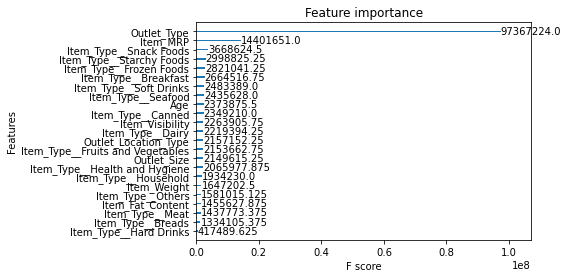

In [69]:
xg = xgb.XGBRegressor()
xg.fit(train.drop('Item_Outlet_Sales',1),train.Item_Outlet_Sales)
xgb.plot_importance(xg, importance_type='gain',grid=False)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Item_Outlet_Sales',1), train.Item_Outlet_Sales, test_size=0.25, random_state=42)

In [73]:
def prediction_function(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor()
    gbr = GradientBoostingRegressor()
    xg = xgb.XGBRegressor()
        
    rf.fit(X_train,y_train)
    predictions_rf = rf.predict(X_test)
    predictions_rf = predictions_rf.astype(int)

    gbr.fit(X_train,y_train)
    predictions_gbr = gbr.predict(X_test)
    predictions_gbr = predictions_gbr.astype(int)

    xg.fit(X_train,y_train)
    predictions_xg = xg.predict(X_test)
    predictions_xg = predictions_xg.astype(int)
    
    mse_rf = (np.sqrt(mean_squared_error(y_test, predictions_rf)))
    mse_gbr = (np.sqrt(mean_squared_error(y_test, predictions_gbr)))
    mse_xg = (np.sqrt(mean_squared_error(y_test, predictions_xg)))

    return(mse_rf, mse_gbr, mse_xg)

In [74]:
mse_rf, mse_gbr, mse_xg = prediction_function(X_train, X_test, y_train, y_test)

In [76]:
print("Random Forest RMSE: "+str(mse_rf))
print("Gradient Boosting RMSE: "+str(mse_gbr))
print("XGBoost RMSE: "+str(mse_xg))

Random Forest RMSE: 1115.2887862588702
Gradient Boosting RMSE: 1053.0851806798223
XGBoost RMSE: 1133.9535120765113


In [77]:
parameters = {'learning_rate':[0.01,0.02,0.03,0.04],'subsample':[0.9, 0.5, 0.2, 0.1],'n_estimators':[100,500,1000, 1500],'max_depth': [4,6,8,10]
                 }

In [80]:
gbr = GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [81]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.04, max_depth=4, subsample=0.9)

 The best score across ALL searched params:
 0.5905429424637124

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}


In [82]:
pred = grid_GBR.best_estimator_.predict(validation)
pred = pred.astype(int)

In [83]:
sub = pd.DataFrame({'Item_Identifier' : va['Item_Identifier'], 'Outlet_Identifier' : va['Outlet_Identifier'], 'Item_Outlet_Sales' : pred})
sub.to_csv('./output.csv', index=False)